# Import 函式庫及設備測試

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#used to check the current environment
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.__version__


Num GPUs Available:  1


'2.9.1'

# 讀取及建立 Dataset

In [3]:
data_dir = "CUB_200_2011/images"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

11788


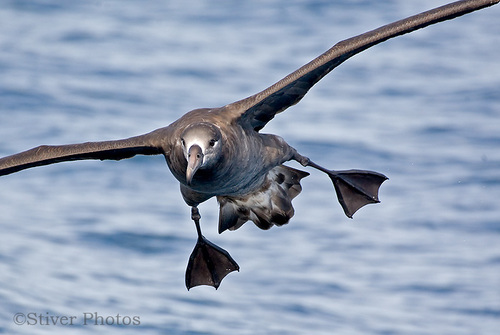

In [4]:
roses = list(data_dir.glob('001.Black_footed_Albatross/*'))
PIL.Image.open(str(roses[3]))

In [5]:
batch_size = 64
img_height = 112
img_width = 112

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11788 files belonging to 200 classes.
Using 9431 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11788 files belonging to 200 classes.
Using 2357 files for validation.


In [8]:
class_names = train_ds.class_names
#print(class_names)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 112, 112, 3)
(64,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
#no need to execute if do rescaling in model
'''
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''

0.0003195403 0.9665946


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Flatten(),  
  
  layers.Dense(512, activation='relu', kernel_initializer='normal'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax', kernel_initializer='normal')
])

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                  

In [17]:
epochs=20

#EARLY_STOPPING = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
 # callbacks = [EARLY_STOPPING]
)

Epoch 1/20
148/148 [==============================] - 17s 71ms/step - loss: 5.3108 - accuracy: 0.0043 - val_loss: 5.2731 - val_accuracy: 0.0076
Epoch 2/20
148/148 [==============================] - 10s 64ms/step - loss: 5.1676 - accuracy: 0.0116 - val_loss: 5.0609 - val_accuracy: 0.0119
Epoch 3/20
148/148 [==============================] - 9s 64ms/step - loss: 4.9767 - accuracy: 0.0197 - val_loss: 4.8879 - val_accuracy: 0.0191
Epoch 4/20
148/148 [==============================] - 10s 65ms/step - loss: 4.8123 - accuracy: 0.0315 - val_loss: 4.6794 - val_accuracy: 0.0403
Epoch 5/20
148/148 [==============================] - 10s 64ms/step - loss: 4.6437 - accuracy: 0.0442 - val_loss: 4.5634 - val_accuracy: 0.0535
Epoch 6/20
148/148 [==============================] - 10s 64ms/step - loss: 4.4272 - accuracy: 0.0633 - val_loss: 4.3992 - val_accuracy: 0.0679
Epoch 7/20
148/148 [==============================] - 9s 64ms/step - loss: 4.1710 - accuracy: 0.0919 - val_loss: 4.2274 - val_accuracy: 0

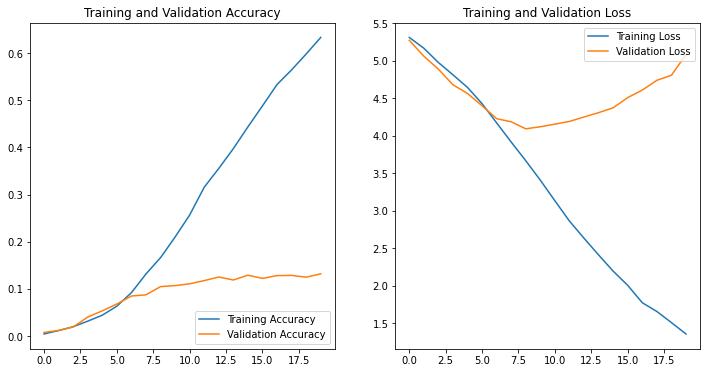

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
#epochs_range = range(11)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
#data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

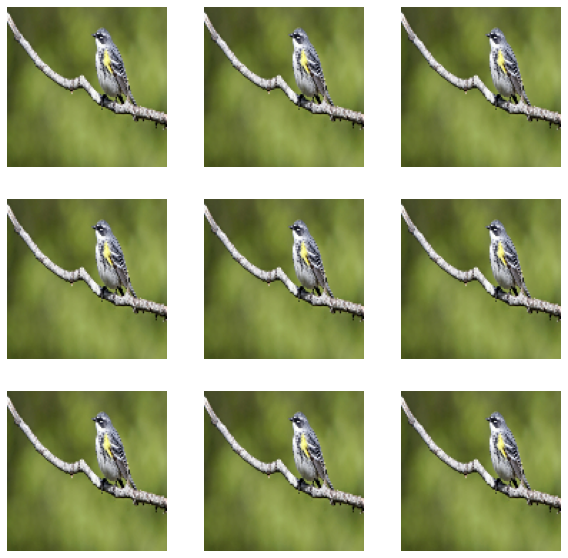

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
    
  layers.Flatten(),  
  
  layers.Dense(512, activation='relu', kernel_initializer='normal'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax', kernel_initializer='normal')
])

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 112, 112, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                      

In [24]:
epochs=40

EARLY_STOPPING = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks = [EARLY_STOPPING]
)

Epoch 1/40
148/148 [==============================] - 19s 123ms/step - loss: 5.2776 - accuracy: 0.0067 - val_loss: 5.1804 - val_accuracy: 0.0051
Epoch 2/40
148/148 [==============================] - 18s 124ms/step - loss: 5.1000 - accuracy: 0.0122 - val_loss: 5.0286 - val_accuracy: 0.0085
Epoch 3/40
148/148 [==============================] - 18s 123ms/step - loss: 4.9602 - accuracy: 0.0147 - val_loss: 4.9512 - val_accuracy: 0.0127
Epoch 4/40
148/148 [==============================] - 18s 124ms/step - loss: 4.8961 - accuracy: 0.0173 - val_loss: 4.8888 - val_accuracy: 0.0178
Epoch 5/40
148/148 [==============================] - 18s 124ms/step - loss: 4.8380 - accuracy: 0.0184 - val_loss: 4.8378 - val_accuracy: 0.0246
Epoch 6/40
148/148 [==============================] - 18s 122ms/step - loss: 4.8119 - accuracy: 0.0211 - val_loss: 4.8188 - val_accuracy: 0.0255
Epoch 7/40
148/148 [==============================] - 18s 123ms/step - loss: 4.7756 - accuracy: 0.0238 - val_loss: 4.7935 - val_ac

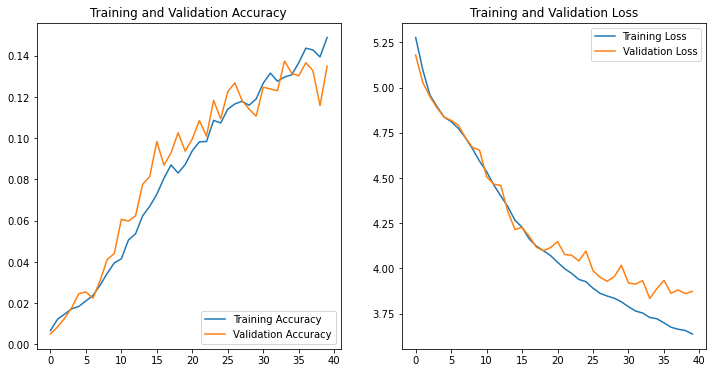

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
#epochs_range = range(11)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
